# Where we are...
* Now that we have the compute infrastructure (AWS)
* and did a *bit* of research on the leaderboard approaches
* We need to get familiar with the dataset
### This notebook gets back to the dataset
### pandas dataFrame is also reviewed (by necessity)

* There's a lot of info (almomst too much)
  * From the kaggle site (discussion -> info for the challenge...)
  * https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit
  * Section 3...


* Start with our "Titanic" basic wrangling...
* Then look at the "starter kit"
* Then look at btrotta

In [67]:
import pandas as pd
import numpy as np
import gc
import os

* there are:
  * [test/train]_set_metadata
  * [test/train]_set
  * test_set_sample - a small (1M lines of test data)
  * sample_submission - example submission file

```

            Training                 "Test"                  aggregated     Validation
            ---------------------    -----------------       -----------    ------------

metadata    training_set_metadata    test_set_metadata 
            (7800 x 12)              (3.4M x 11)
 (btrotta)  "train_meta"             "test_meta"             "all_meta"


timeseries  training_set             test_set_samples        "xxx"
            (1.4M x 6)               (1.0M x 6)
 (btrotta)  "train"                  "test"

                                     (poorly named "Test"
                                     it is unlabeled data)
```



In [70]:
# read data
col_dict = {'mjd': np.float64, 'flux': np.float32, 'flux_err': np.float32, 'object_id': np.int32, 'passband': np.int8,
            'detected': np.int8}
train_meta = pd.read_csv(os.path.join('data', 'training_set_metadata.csv'))
train = pd.read_csv(os.path.join('data', 'training_set.csv'), dtype=col_dict)

In [71]:
test_meta = pd.read_csv(os.path.join('data', 'test_set_metadata.csv'))
test = pd.read_csv(os.path.join('data', 'test_set_sample.csv'), dtype=col_dict)

In [72]:
print(train_meta.shape)
print(train.shape)
print(test_meta.shape)
print(test.shape)

(7848, 12)
(1421705, 6)
(3492890, 11)
(1000000, 6)


# first look at the metadata (unchanging in time)
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit#4.-Primer-cont'd---Metadata-Provided-with-Light-Curves


* information about an object that doesn't change over time
  * object_id - unique identifier
  * ra - right ascension
  * decl - declination
  * gal_l - galactic longitude
  * gal_b - galactic latitude
  * ddf - flag that indicates data is from ddf survey (otherwise WFD)
  * hostgal_specz - spectrographic redshift of the source  - accurate measure of redshift - available in training and small part of test set
  * hostgal_photoz - photometric redshift - meant as proxy for hostgal_specz but less accurate
  * hostgal_photoz_err - uncertainty in above
  * distmod - distance to source calculated from hostgal_photoz 
  * mwebv - extinction of light property along line of sight to milky way
  * target = class of astronomical source

In [3]:
train_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


## short aside... pd dataframe indexing and boolean selection...
* if you're reviewing pandas DataFrame... good 2-part tutorial at:
* https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c
* https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-39e811c81a0c

In [4]:
train_meta.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')

In [5]:
train_meta.head().index

RangeIndex(start=0, stop=5, step=1)

In [6]:
train_meta.head().values

array([[ 6.15000000e+02,  3.49046051e+02, -6.19438360e+01,
         3.20796530e+02, -5.17537060e+01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                    nan,  1.70000000e-02,  9.20000000e+01],
       [ 7.13000000e+02,  5.30859380e+01, -2.77844050e+01,
         2.23525509e+02, -5.44607480e+01,  1.00000000e+00,
         1.81810000e+00,  1.62670000e+00,  2.55200000e-01,
         4.54063000e+01,  7.00000000e-03,  8.80000000e+01],
       [ 7.30000000e+02,  3.35742190e+01, -6.57959300e+00,
         1.70455585e+02, -6.15482190e+01,  1.00000000e+00,
         2.32000000e-01,  2.26200000e-01,  1.57000000e-02,
         4.02561000e+01,  2.10000000e-02,  4.20000000e+01],
       [ 7.45000000e+02,  1.89873000e-01, -4.55866550e+01,
         3.28254458e+02, -6.89692980e+01,  1.00000000e+00,
         3.03700000e-01,  2.81300000e-01,  1.15230000e+00,
         4.07951000e+01,  7.00000000e-03,  9.00000000e+01],
       [ 1.12400000e+03,  3.52711273e+02, -6.3823658

In [7]:
# using ".loc" and 'just the index operator'
a = train_meta.head()["target"]
b = train_meta.head()[["target"]]
c = train_meta.head().loc[3]
d = train_meta.head().loc[[0,3]]
e = train_meta.head().loc[[0,3],["target"]]
print(type(a), a.shape)
print(type(b), b.shape)
print(type(c), c.shape)
print(type(d), d.shape)
print(type(e), e.shape)

print("---\n",c)
print("---\n",d)
print("---\n",e)

<class 'pandas.core.series.Series'> (5,)
<class 'pandas.core.frame.DataFrame'> (5, 1)
<class 'pandas.core.series.Series'> (12,)
<class 'pandas.core.frame.DataFrame'> (2, 12)
<class 'pandas.core.frame.DataFrame'> (2, 1)
---
 object_id             745.000000
ra                      0.189873
decl                  -45.586655
gal_l                 328.254458
gal_b                 -68.969298
ddf                     1.000000
hostgal_specz           0.303700
hostgal_photoz          0.281300
hostgal_photoz_err      1.152300
distmod                40.795100
mwebv                   0.007000
target                 90.000000
Name: 3, dtype: float64
---
    object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017  

In [8]:
train_meta.loc[[3,5],["target"]]

,target
3,90
5,65


In [9]:
train_meta.loc[3:5,["target"]]

,target
3,90
4,90
5,65


In [10]:
# this is an overload of the 'just the index operator' where it is given a slice
# in this case it is ROW selection !
train_meta.head()[3:5]

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [11]:
# this is an overload of the 'just the index operator' where it is given a list of booleans
# in this case it is ROW selection
# it is the basis of boolean indexing
train_meta.head()[[True, True, False, False, True]]

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


### q: how many target class?

In [12]:
train_meta["target"].unique()

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53],
      dtype=int64)

### a: there are 14 classes in the "train_meta" set.


### q: describe(), corr(), info()

In [13]:
train_meta.describe()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
count,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,5523.000000,7848.000000,7848.000000
mean,4.810375e+07,169.719379,-27.254846,230.466784,-20.115526,0.269623,0.254436,0.357885,0.155695,41.263961,0.081953,60.895387
std,4.347364e+07,114.212761,20.248556,97.416392,40.390899,0.443792,0.330053,0.545552,0.300367,2.262711,0.150598,28.767984
min,6.150000e+02,0.175781,-64.760857,0.107681,-89.615573,0.000000,0.000000,0.000000,0.000000,31.996100,0.003000,6.000000
25%,3.180865e+05,62.402344,-44.597992,207.248509,-54.509752,0.000000,0.000000,0.000000,0.000000,39.845250,0.018000,42.000000
50%,4.131719e+07,150.996094,-27.279613,244.127187,-30.217582,0.000000,0.182750,0.210300,0.018000,41.167900,0.032000,65.000000
75%,8.665901e+07,282.875976,-8.838267,313.224277,16.913859,1.000000,0.350125,0.431200,0.122375,42.398550,0.076000,90.000000
max,1.307798e+08,359.824219,4.181528,359.943827,65.931317,1.000000,3.445100,2.999400,1.734800,47.025600,2.747000,95.000000


In [14]:
train_meta.corr()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
object_id,1.000000,0.018335,0.047821,-0.123909,0.155451,-0.669899,-0.057409,-0.017225,-0.018940,-0.042652,0.171717,-0.122899
ra,0.018335,1.000000,-0.237186,-0.086194,0.102386,-0.033685,-0.007056,-0.001598,-0.012703,-0.000518,0.028959,-0.014805
decl,0.047821,-0.237186,1.000000,-0.479090,0.389756,-0.081657,-0.013626,-0.011385,-0.020795,-0.016917,-0.000572,-0.018324
gal_l,-0.123909,-0.086194,-0.479090,1.000000,0.186651,0.192074,0.011569,-0.010038,0.003269,0.022230,-0.046744,0.025688
gal_b,0.155451,0.102386,0.389756,0.186651,1.000000,-0.227252,-0.092992,-0.081450,-0.054421,-0.031091,0.233316,-0.119809
ddf,-0.669899,-0.033685,-0.081657,0.192074,-0.227252,1.000000,0.086603,0.042447,0.027191,0.082416,-0.267189,0.181522
hostgal_specz,-0.057409,-0.007056,-0.013626,0.011569,-0.092992,0.086603,1.000000,0.550373,0.106962,0.583446,-0.146782,0.412562
hostgal_photoz,-0.017225,-0.001598,-0.011385,-0.010038,-0.081450,0.042447,0.550373,1.000000,0.491055,0.867516,-0.112734,0.244450
hostgal_photoz_err,-0.018940,-0.012703,-0.020795,0.003269,-0.054421,0.027191,0.106962,0.491055,1.000000,0.306534,-0.084931,0.110821
distmod,-0.042652,-0.000518,-0.016917,0.022230,-0.031091,0.082416,0.583446,0.867516,0.306534,1.000000,-0.062727,0.274068


In [15]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Data columns (total 12 columns):
object_id             7848 non-null int64
ra                    7848 non-null float64
decl                  7848 non-null float64
gal_l                 7848 non-null float64
gal_b                 7848 non-null float64
ddf                   7848 non-null int64
hostgal_specz         7848 non-null float64
hostgal_photoz        7848 non-null float64
hostgal_photoz_err    7848 non-null float64
distmod               5523 non-null float64
mwebv                 7848 non-null float64
target                7848 non-null int64
dtypes: float64(9), int64(3)
memory usage: 735.9 KB


In [16]:
# train_meta.describe(include=['O'])
# (there are no categorical attributes)

### q: how many nulls?

In [17]:
train_meta.isnull().sum()

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
dtype: int64

### distmot is distance computed from spec-z and photo-z
* a good number of "distmod" are NaN
* Question- is "distmod=NaN" the result when both "specz" and "photoz" are zero?

### here we will use pandas "boolean selection"
* *find all entries with spez=0*
* *find all entries with both spez and photoz=0*
* *find all entries with distmod=NaN*

In [18]:
criteria = train_meta["target"] == 90
#print(criteria)
train_meta_with_target_90 = train_meta[criteria]
#print(train_meta_with_target_90)
print(train_meta.shape)
print(train_meta_with_target_90.shape)

(7848, 12)
(2313, 12)


In [19]:
print(train_meta[train_meta["target"]==92].shape)
print(train_meta[train_meta["target"]==88].shape)
print(train_meta[train_meta["target"]==42].shape)
print(train_meta[train_meta["target"]==90].shape)
print(train_meta[train_meta["target"]==65].shape)
print(train_meta[train_meta["target"]==16].shape)
print(train_meta[train_meta["target"]==67].shape)
print(train_meta[train_meta["target"]==95].shape)
print(train_meta[train_meta["target"]==62].shape)
print(train_meta[train_meta["target"]==15].shape)
print(train_meta[train_meta["target"]==52].shape)
print(train_meta[train_meta["target"]==6].shape)
print(train_meta[train_meta["target"]==64].shape)
print(train_meta[train_meta["target"]==53].shape)


(239, 12)
(370, 12)
(1193, 12)
(2313, 12)
(981, 12)
(924, 12)
(208, 12)
(175, 12)
(484, 12)
(495, 12)
(183, 12)
(151, 12)
(102, 12)
(30, 12)


# so there are between 30 and 2313 examples of each class in the training set
### this is a very small number of examples
* *subject to over-training*
* *several competitors added noise to the data to avoid over-training*
* *maybe another approach would be to use instance-based learning?*

# getting back to the question of "distmod"...

In [20]:
# Q: how many distmod are NaN?
# Q: which spez are zero?
# Q: which photoz are zero?
# Q: Of the samples with distmod NaN - which ones have non-zero spez?
# Q: Of the samples with distmod NaN - which ones have non-zero photoz?
import math
criteria_1 = train_meta["distmod"].isna()
criteria_2 = train_meta["hostgal_specz"] == 0
criteria_3 = train_meta["hostgal_photoz"] == 0

criteria_1_and_not_2 = criteria_1 & ~criteria_2
criteria_1_and_not_3 = criteria_1 & ~criteria_3

result_1 = train_meta[criteria_1]
result_2 = train_meta[criteria_1_and_not_2]
result_3 = train_meta[criteria_1_and_not_3]

print(train_meta.shape)
print(result_1.shape)
print(result_2.shape)
print(result_3.shape)

# in summary - a distmod of "NaN" is always associated with BOTH "z" values of zero
# we would want to re-verify this on the test dataset...

(7848, 12)
(2325, 12)
(0, 12)
(0, 12)


### *there is more in the tutorial...*
* *isin, isnull, operations on a Series, between, combining row and column selection, boolean selection of columnns*
* *column-to-column comparison*



### and *avoid chained indexing!*
* NO

`df[df['age'] > 10]['score'] = 99`
* YES

`df.loc[df['age'] > 10, 'score'] = 99`


In [21]:
# example of shallow copy!
a1 = [0, 1, 2, 3]
b1 = a1
b1[0] = 99
print(b1)
print(a1)
print(id(a1))
print(id(b1))

[99, 1, 2, 3]
[99, 1, 2, 3]
2182042363592
2182042363592


In [22]:
# deep copy
import copy
a1 = [0, 1, 2, 3]
b1 = copy.deepcopy(a1)
b1[0] = 99
print(b1)
print(a1)
print(id(a1))
print(id(b1))

[99, 1, 2, 3]
[0, 1, 2, 3]
2182042277000
2182041629576


# moving on to the time sample data
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit#2.-A-Primer-on-the-Dataset---Light-Curves

* object_id = the object id
* mjd = date of the sample
* passband = the frequency band used at the time of the sample
* flux = overall brightness
* flux_err = flux error
* detected = indicates the "template" technique is used to detect the object


In [23]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421705 entries, 0 to 1421704
Data columns (total 6 columns):
object_id    1421705 non-null int32
mjd          1421705 non-null float64
passband     1421705 non-null int8
flux         1421705 non-null float32
flux_err     1421705 non-null float32
detected     1421705 non-null int8
dtypes: float32(2), float64(1), int32(1), int8(2)
memory usage: 29.8 MB


In [25]:
train.describe()

,object_id,mjd,passband,flux,flux_err,detected
count,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06
mean,3.392608e+07,6.017921e+04,2.783108e+00,2.468856e+01,2.548932e+01,1.666168e-01
std,4.258439e+07,3.092379e+02,1.703946e+00,3.684506e+03,3.814491e+03,3.726336e-01
min,6.150000e+02,5.958003e+04,0.000000e+00,-1.149388e+06,4.637530e-01,0.000000e+00
25%,1.843400e+05,5.989905e+04,1.000000e+00,-2.789418e+00,2.118670e+00,0.000000e+00
50%,4.548783e+06,6.019331e+04,3.000000e+00,7.331990e-01,4.708105e+00,0.000000e+00
75%,6.796280e+07,6.048722e+04,4.000000e+00,8.830932e+00,1.297371e+01,0.000000e+00
max,1.307798e+08,6.067436e+04,5.000000e+00,2.432809e+06,2.234069e+06,1.000000e+00


#### above is worth reviewing...
* there are about 1.4M samples in this (small subset) training set
* date range is 59,000 to 61,000
* 6 passbands (discrete) 0 to 5
* flux     mean 25 std 3700   **(the STD seems high why so much?)***
* flux_err mean 25 std 3800   ***(same question)***


* I need a chart of flux...


In [26]:
train.isnull().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

# next... "Exploring the Light Curves"
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit#3.-Exploring-the-Light-Curves

In [27]:
import os
import numpy as np
import scipy.stats as spstat
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table


%matplotlib inline

In [28]:
class LightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, filename):
        '''Read in light curve data'''

        self.DFlc     = Table.read(filename, format='ascii.csv')
        self.filename = filename.replace('.csv','')
        self._finalize()
     
    # this is some simple code to demonstrate how to calculate features on these multiband light curves
    # we're not suggesting using these features specifically
    # there also might be additional pre-processing you do before computing anything
    # it's purely for illustration
    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = spstat.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        # we can also construct features between passbands
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    # this is a simple routine to visualize a light curve
    # it can plot vs the MJD array of the light curve
    # or vs an optional `phase` array that you pass 
    def plot_multicolor_lc(self, phase=None):
        '''Plot the multiband light curve'''

        fig, ax = plt.subplots(figsize=(8,6))

        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol = 4, frameon = True)
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        fig.suptitle(self.filename, fontsize='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        '''Return all the features for this object'''
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats

C:\Users\Administrator\Documents\code_kaggle_plasticc\kaggle_plasticc\project


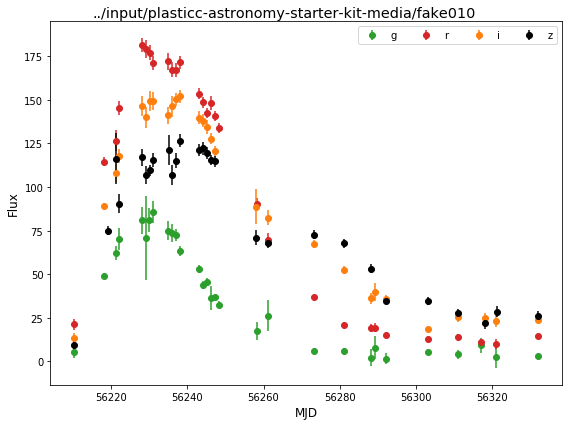

In [29]:
import os
print(os.getcwd())

lc = LightCurve('../input/plasticc-astronomy-starter-kit-media/fake010.csv')

lc.plot_multicolor_lc()

# what the heck is above doing?
* constructor takesin filename, opens/reads that, storing in DFlc (data-frame light curve)
* it *appears to be* a subset of the timesample table for a single object ID #10


In [30]:
lc.DFlc

object_id,mjd,passband,flux,flux_err,detected_bool
int32,float64,int32,float64,float64,int32
10,56210.172,1,5.659,3.7,1
10,56210.188,2,21.32,3.245,1
10,56210.203,3,13.28,3.221,1
10,56210.234,4,9.579,3.85,1
10,56218.172,1,49.22,1.654,1
10,56218.191,2,114.6,2.376,1
10,56218.211,3,88.85,2.261,1
10,56219.156,4,75.01,2.394,1
10,56221.273,1,62.28,4.17,1


In [31]:
# lets see if we can reproduce it...
# (sadly object "10" is not in the training set - lets use 615...)
criteria = train["object_id"] == 615
result = train[criteria]


In [32]:
class MyLightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, dataframe):
        '''Read in light curve data'''

        self.DFlc     = dataframe
        self.filename = 'n/a'
        self._finalize()
     
    # this is some simple code to demonstrate how to calculate features on these multiband light curves
    # we're not suggesting using these features specifically
    # there also might be additional pre-processing you do before computing anything
    # it's purely for illustration
    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = spstat.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        # we can also construct features between passbands
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    # this is a simple routine to visualize a light curve
    # it can plot vs the MJD array of the light curve
    # or vs an optional `phase` array that you pass 
    def plot_multicolor_lc(self, phase=None):
        '''Plot the multiband light curve'''

        fig, ax = plt.subplots(figsize=(8,6))

        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol = 4, frameon = True)
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        fig.suptitle(self.filename, fontsize='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        '''Return all the features for this object'''
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats

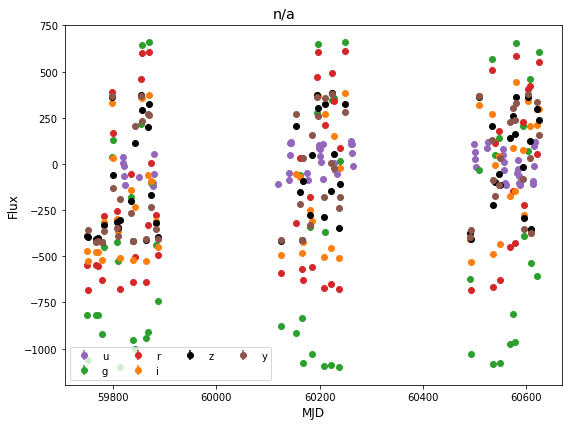

In [33]:
criteria = train["object_id"] == 615
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

# Nice!

# now I want one example of each of the 14 class
recall...

In [34]:
print(train_meta[train_meta["target"]==92].shape)
print(train_meta[train_meta["target"]==88].shape)
print(train_meta[train_meta["target"]==42].shape)
print(train_meta[train_meta["target"]==90].shape)
print(train_meta[train_meta["target"]==65].shape)
print(train_meta[train_meta["target"]==16].shape)
print(train_meta[train_meta["target"]==67].shape)
print(train_meta[train_meta["target"]==95].shape)
print(train_meta[train_meta["target"]==62].shape)
print(train_meta[train_meta["target"]==15].shape)
print(train_meta[train_meta["target"]==52].shape)
print(train_meta[train_meta["target"]==6].shape)
print(train_meta[train_meta["target"]==64].shape)
print(train_meta[train_meta["target"]==53].shape)

(239, 12)
(370, 12)
(1193, 12)
(2313, 12)
(981, 12)
(924, 12)
(208, 12)
(175, 12)
(484, 12)
(495, 12)
(183, 12)
(151, 12)
(102, 12)
(30, 12)


In [35]:
# What is the object_id of the first instance of each class?
# class 92...
id = 92
result = train_meta[train_meta["target"]==id]
print(id)
print(result.loc[[0],["object_id"]])
result.loc[[0]]

92
   object_id
0        615


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [36]:
result.loc[0]

object_id             615.000000
ra                    349.046051
decl                  -61.943836
gal_l                 320.796530
gal_b                 -51.753706
ddf                     1.000000
hostgal_specz           0.000000
hostgal_photoz          0.000000
hostgal_photoz_err      0.000000
distmod                      NaN
mwebv                   0.017000
target                 92.000000
Name: 0, dtype: float64

In [37]:
result.loc[0,"object_id"]

615

In [38]:
# so...
# 1) start with a list of class numbers pdSeries
# create a data-frame with this as one of the columns
# create a function that maps from class to object_id (using the code above, selecting the first instance)
#
# or just do it the slow way...

In [39]:
def target_id_to_first_object_id(cols):
    target_id = cols[0]
    print("here", target_id)
    result = train_meta[train_meta["target"]==target_id]
    result.reset_index(drop=True, inplace=True)    
    y = result.loc[0, "object_id"]
    return y

In [40]:
train_meta

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65


In [41]:
d = {'target_id': [
    92,
    88,
    42,
    90,
    65,
    16,
    67,
    95,
    62,
    15,
    52,
    6,
    64,
    53]}

#d = {'target_id': [
#    92,
#    88
#]}

target_id_to_object_id_df = pd.DataFrame(data=d, dtype=np.int64)
target_id_to_object_id_df

,target_id
0,92
1,88
2,42
3,90
4,65
5,16
6,67
7,95
8,62
9,15


In [42]:
target_id_to_object_id_df['object_id'] = 35

target_id_to_object_id_df

,target_id,object_id
0,92,35
1,88,35
2,42,35
3,90,35
4,65,35
5,16,35
6,67,35
7,95,35
8,62,35
9,15,35


In [43]:
#y = first_object_id_from_target_id(target_list)

# create object_id from target_id

target_id_to_object_id_df['object_id'] = target_id_to_object_id_df[['target_id']].apply(target_id_to_first_object_id, axis = 1)
#train_df['Age_Bracket'] = train_df[['Age']].apply(age_to_age_bracket, axis = 1)

#target_id_to_object_id_df[['target_id']].apply(target_id_to_first_object_id, axis = 1)

#target_id_to_object_id_df[['target_id']].apply(target_id_to_first_object_id, axis=1)

here 92
here 88
here 42
here 90
here 65
here 16
here 67
here 95
here 62
here 15
here 52
here 6
here 64
here 53


In [44]:
target_id_to_object_id_df

,target_id,object_id
0,92,615
1,88,713
2,42,730
3,90,745
4,65,1227
5,16,2677
6,67,2922
7,95,3423
8,62,3910
9,15,4173


In [45]:
target_id_to_object_id_df["object_id"].values

array([   615,    713,    730,    745,   1227,   2677,   2922,   3423,
         3910,   4173,  10757,  18556,  62187, 133773], dtype=int64)

# OK - we have example objects of each class...

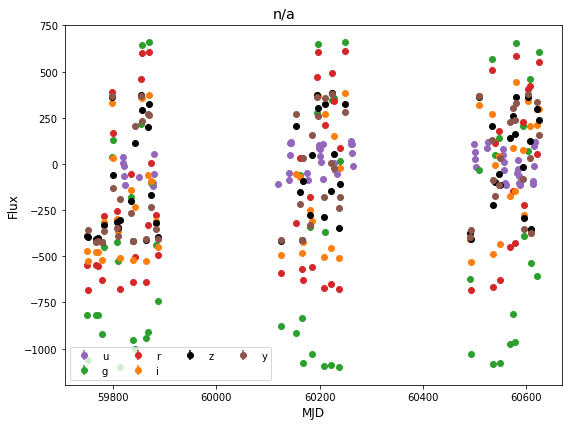

In [46]:
criteria = train["object_id"] == 615
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

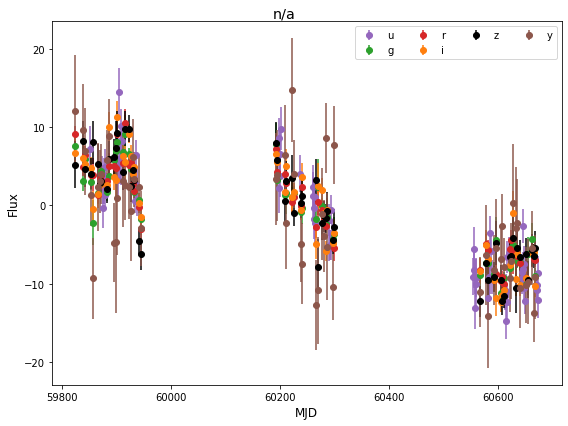

In [47]:
criteria = train["object_id"] == 713
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

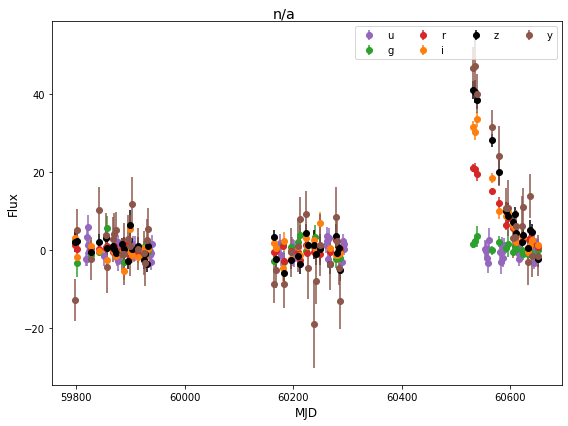

In [48]:
criteria = train["object_id"] == 730
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

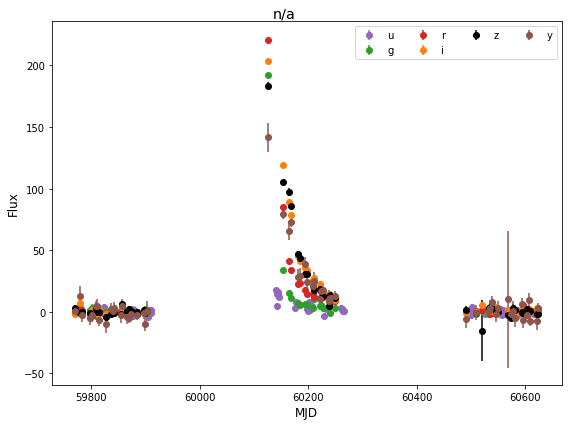

In [49]:
criteria = train["object_id"] == 745
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

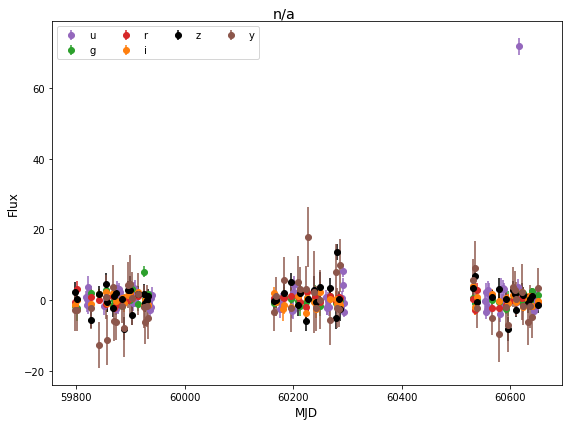

In [50]:
criteria = train["object_id"] == 1227
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

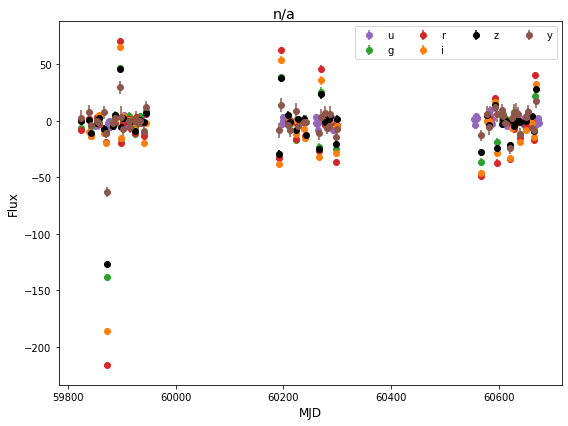

In [51]:
criteria = train["object_id"] == 2677
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

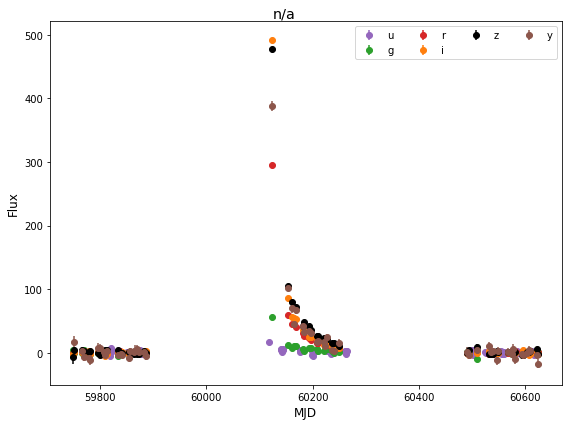

In [52]:
criteria = train["object_id"] == 2922
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

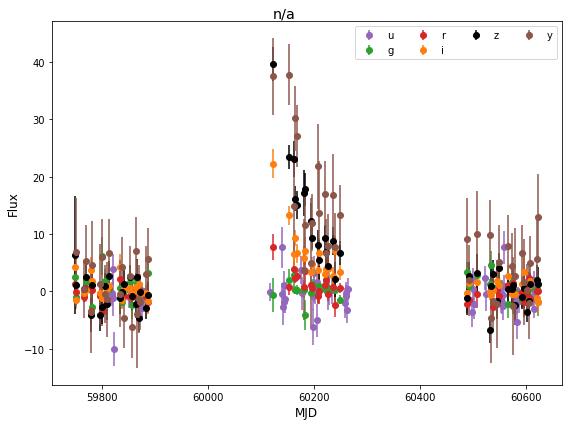

In [53]:
criteria = train["object_id"] == 3423
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

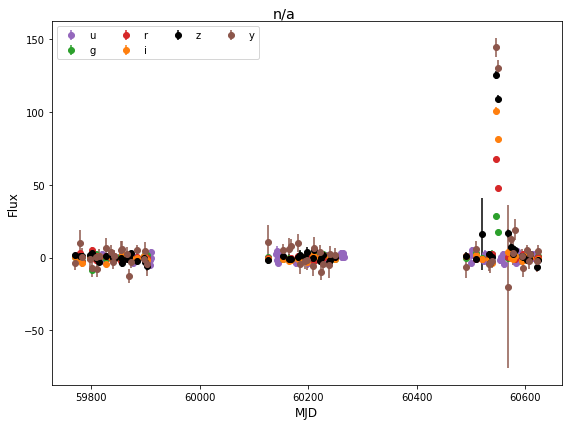

In [54]:
criteria = train["object_id"] == 3910
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

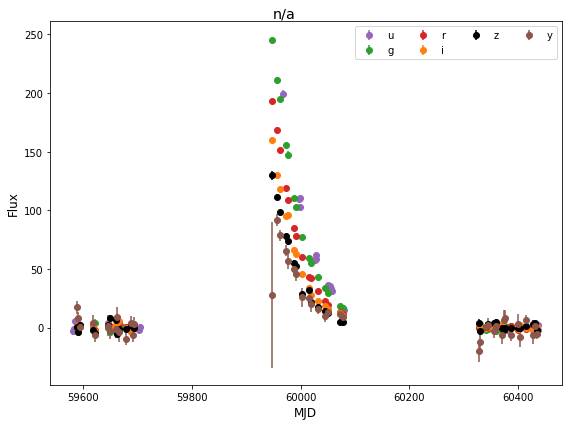

In [55]:
criteria = train["object_id"] == 4173
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

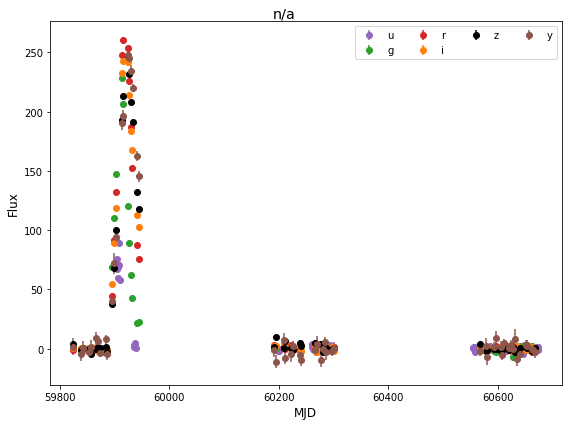

In [56]:
criteria = train["object_id"] == 10757
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

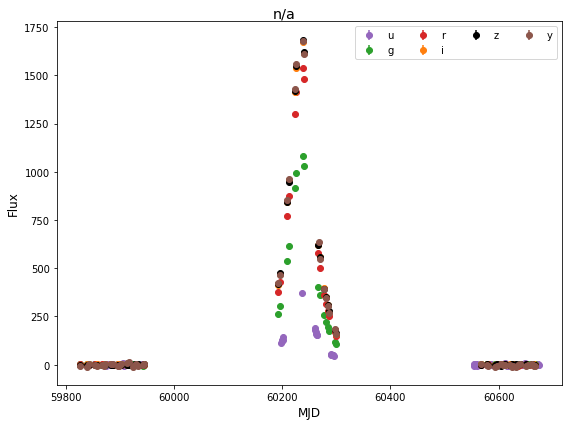

In [57]:
criteria = train["object_id"] == 18556
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

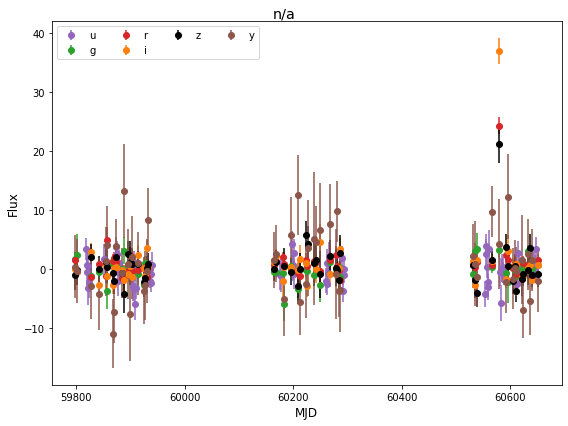

In [58]:
criteria = train["object_id"] == 62187
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

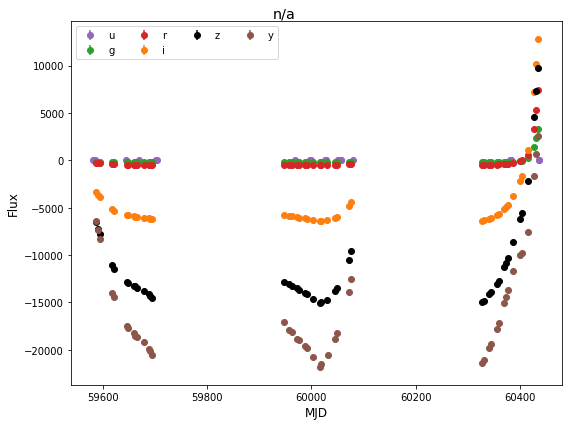

In [59]:
criteria = train["object_id"] == 133773
result = train[criteria]
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()